# Classification and Logistic Regression: Distinguishing RGB and Red Clump Stars

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 7 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

In our exploration of regression methods, we've established powerful frameworks for predicting continuous astronomical quantities—from stellar parameters to photometric redshifts. Yet many fundamental questions in astronomy require a different approach: determining which discrete category an object belongs to. Is this object a star or a galaxy? Is this transient a supernova or an active galactic nucleus? Is this star on the red giant branch or has it evolved to the red clump phase?

This shift from continuous prediction to categorical classification represents more than a technical adjustment—it reflects the discrete nature of many astrophysical phenomena. Stars occupy distinct evolutionary stages. Galaxies fall into morphological types. Transient events arise from specific physical mechanisms. These natural categorizations make classification a cornerstone of astronomical data analysis.

The transition from regression to classification parallels the historical development of astronomical catalogs. Early surveys focused on continuous measurements: positions, brightnesses, colors. Modern surveys increasingly emphasize classification: identifying quasars among billions of point sources, distinguishing planetary transits from stellar variability, or separating gravitational lensing events from intrinsic source variation. Each classification decision enables targeted follow-up observations and population studies that would be impossible without reliable automated classification.

Logistic regression provides an elegant bridge between the linear methods we've studied and the classification problems we now face. By applying a simple nonlinear transformation—the sigmoid function—to our familiar linear model, we obtain probabilities that quantify our confidence in each classification. This probabilistic framework proves essential when dealing with noisy astronomical data, where sharp categorical boundaries rarely exist.

The specific application we'll explore—distinguishing Red Clump (RC) from Red Giant Branch (RGB) stars—exemplifies the power of classification in modern astronomy. RC stars serve as "standard candles" due to their remarkably consistent luminosity, enabling distance measurements far beyond the reach of parallax methods. However, their utility depends critically on our ability to distinguish them from RGB stars, which occupy similar regions of color-magnitude space but lack the distance-indicating properties of RC stars. This classification challenge directly impacts our ability to map the three-dimensional structure of our Galaxy.



## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Python Programming**: Working knowledge of NumPy arrays, matplotlib visualization, and basic scipy functionality
- **Linear Regression**: Understanding of linear models, least squares fitting, and the concept of model parameters
- **Probability Theory**: Basic understanding of probability distributions, likelihood, and Bayesian concepts
- **Optimization**: Familiarity with gradient descent and the concept of loss functions

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Model Adaptation**: Transforming linear models for classification tasks through appropriate link functions
- **Probabilistic Classification**: Understanding how the sigmoid function converts linear outputs to well-calibrated probabilities
- **Optimization Implementation**: Building gradient descent algorithms from scratch, including mini-batch variants
- **Performance Evaluation**: Applying appropriate metrics for imbalanced classification problems in astronomy
- **Hyperparameter Optimization**: Systematically tuning model parameters to maximize performance on unseen data
- **Scientific Interpretation**: Extracting physically meaningful insights from learned model parameters

 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from sklearn.model_selection import train_test_split

# Configure plotting parameters to match textbook style
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## The Astronomical Challenge: Red Clump Stars as Distance Indicators

The determination of accurate distances remains one of the fundamental challenges in astronomy. While parallax measurements from missions like Gaia revolutionized nearby stellar astronomy, their precision degrades quadratically with distance. For stars beyond a few kiloparsecs—encompassing most of our Galaxy—we require alternative distance indicators.

Red Clump stars offer an elegant solution to this challenge. These stars, burning helium in their cores after the helium flash, occupy a remarkably narrow range of absolute magnitudes across a wide range of metallicities and ages. This consistency arises from the physics of helium burning: the process self-regulates to produce nearly identical core conditions regardless of the star's prior evolution. Consequently, RC stars function as "standard candles"—objects of known intrinsic brightness whose distances can be inferred from their apparent magnitudes.

The practical utility of RC stars depends critically on our ability to distinguish them from Red Giant Branch stars. RGB stars, ascending the giant branch while burning hydrogen in a shell around an inert helium core, populate similar regions of temperature-gravity space but exhibit a wide range of luminosities. Misclassifying an RGB star as RC would lead to catastrophic distance errors, potentially placing the star at entirely the wrong location within the Galaxy.

Traditional identification of RC stars relies on asteroseismology—the study of stellar oscillations. The distinct internal structure of RC stars, particularly their convective cores surrounded by radiative envelopes, produces characteristic oscillation patterns distinguishable from those of RGB stars. However, obtaining high-quality asteroseismic data requires long-duration, high-cadence photometry from missions like Kepler or TESS, limiting coverage to small fields.

Fortunately, the transition from RGB to RC phase induces subtle but measurable changes in stellar atmospheres. The onset of core helium burning alters the star's structure, affecting observable quantities like effective temperature, surface gravity, and chemical abundance patterns. Modern spectroscopic surveys like APOGEE measure these properties for millions of stars, providing the raw material for spectroscopic classification approaches.

In [3]:
# Load the APOGEE dataset with asteroseismic classifications
data = np.load("dataset_apogee_asteroseismic.npz")
X = data["data"]  # Feature matrix
t = data["label"]  # Labels (1 for RC, 0 for RGB)

# Feature descriptions
feature_names = ['Teff', 'log g', '[Fe/H]', 'RA', 'Dec', 'J', 'H', 'K']

print("Dataset Characteristics:")
print(f"Total number of stars: {X.shape[0]:,}")
print(f"Number of spectroscopic features: {X.shape[1]}")
print(f"Class distribution:")
print(f"  - Red Giant Branch (RGB) stars: {np.sum(t == 0):,}")
print(f"  - Red Clump (RC) stars: {np.sum(t == 1):,}")
print(f"  - Class ratio (RC/RGB): {np.sum(t == 1)/np.sum(t == 0):.2f}")

Dataset Characteristics:
Total number of stars: 2,855
Number of spectroscopic features: 8
Class distribution:
  - Red Giant Branch (RGB) stars: 730
  - Red Clump (RC) stars: 2,125
  - Class ratio (RC/RGB): 2.91


Our APOGEE dataset contains spectroscopic measurements for 2,855 stars, with asteroseismic classifications serving as ground truth. Each star is characterized by eight observational features that capture both intrinsic stellar properties and observational characteristics:

**Spectroscopic Parameters:**
- **Effective temperature (Teff)**: The temperature of a blackbody that would emit the same total electromagnetic radiation as the star. For evolved stars, this ranges from approximately 4,000 to 5,500 K.
- **Surface gravity (log g)**: The logarithm of the gravitational acceleration at the stellar photosphere. This fundamental parameter directly relates to the star's mass and radius through $g = GM/R^2$.
- **Metallicity ([Fe/H])**: The logarithmic iron abundance relative to the Sun, serving as a proxy for the star's overall metal content and formation environment.

**Observational Properties:**
- **Sky coordinates (RA, Dec)**: The celestial position, included to test whether our classifier inappropriately uses spatial information.
- **Near-infrared magnitudes (J, H, K)**: Apparent brightnesses in the 2MASS photometric system, sensitive to both distance and intrinsic luminosity.

The labels derive from asteroseismic analysis—the gold standard for distinguishing evolutionary states. Asteroseismology detects the distinct oscillation modes that arise from RC stars' helium-burning cores versus RGB stars' inert helium cores. This provides reliable "ground truth" labels for training our spectroscopic classifier.

Let's visualize how these populations distribute in the fundamental plane of stellar astrophysics:

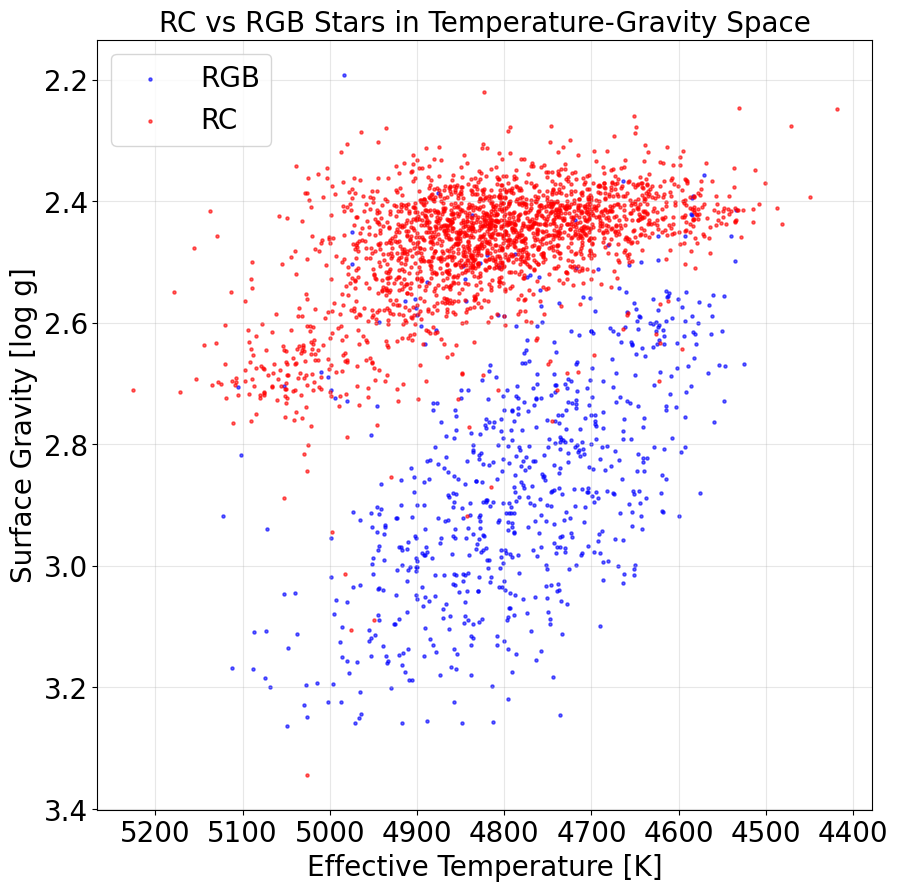

In [5]:
# Visualize the stellar populations in temperature-gravity space
plt.figure(figsize=(10, 10))

# Plot RGB stars (label = 0) in blue
plt.scatter(X[t == 0, 0], X[t == 0, 1], c='blue', s=5, alpha=0.6, label='RGB')
# Plot Red Clump stars (label = 1) in red
plt.scatter(X[t == 1, 0], X[t == 1, 1], c='red', s=5, alpha=0.6, label='RC')

# Customize the plot to match stellar astrophysics conventions
plt.gca().invert_xaxis()  # Higher temperature on the left
plt.gca().invert_yaxis()  # Lower gravity (more evolved) at top
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('RC vs RGB Stars in Temperature-Gravity Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The temperature-gravity diagram reveals the fundamental challenge of spectroscopic classification. While RC stars (red points) cluster tightly around log g ≈ 2.5, reflecting their uniform evolutionary state during core helium burning, RGB stars (blue points) span a broader range of surface gravities. This dispersion arises from the continuous nature of RGB evolution—as stars ascend the giant branch, their radii increase and surface gravities decrease monotonically.

The overlap between populations is particularly pronounced at intermediate gravities (log g ≈ 2.7–3.0), where ascending RGB stars and settled RC stars occupy indistinguishable regions of parameter space. This overlap precludes simple threshold-based classification and motivates our probabilistic approach. Rather than drawing arbitrary boundaries, logistic regression will learn to quantify the probability that a star with given spectroscopic properties belongs to the RC population.

The tight clustering of RC stars also explains their utility as distance indicators. Their narrow distribution in fundamental parameters translates to a narrow luminosity function, making them reliable standard candles. The challenge lies in cleanly separating them from the contaminating RGB population—a task ideally suited to machine learning classification.

## From Linear to Logistic Regression

In our previous explorations of regression methods, we modeled continuous astronomical quantities through linear combinations of features. For predicting stellar parameters or photometric redshifts, this approach proved remarkably effective. However, classification presents a fundamental challenge: we need to predict discrete categories rather than continuous values.

Consider the naive approach of directly applying linear regression to our binary labels (0 for RGB, 1 for RC). A linear model $\mathbf{w}^T\mathbf{x}$ can output any real number, yet our labels are constrained to {0, 1}. More problematically, interpreting predictions outside [0, 1] as probabilities violates basic axioms—probabilities cannot be negative or exceed unity.

Logistic regression elegantly resolves this challenge through the sigmoid function:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

This transformation maps any real-valued input to the interval (0, 1), ensuring valid probability outputs. The function exhibits several desirable properties:
- **Monotonicity**: Larger linear outputs yield higher probabilities
- **Symmetry**: $\sigma(-z) = 1 - \sigma(z)$
- **Smooth gradients**: Enabling efficient optimization

For stellar classification, this means our model computes:

$$P(\text{RC}|\mathbf{x}, \mathbf{w}) = \sigma(\mathbf{w}^T\mathbf{x})$$

The linear term $\mathbf{w}^T\mathbf{x}$ captures how spectroscopic features combine to indicate stellar type, while the sigmoid transformation ensures a valid probability interpretation.

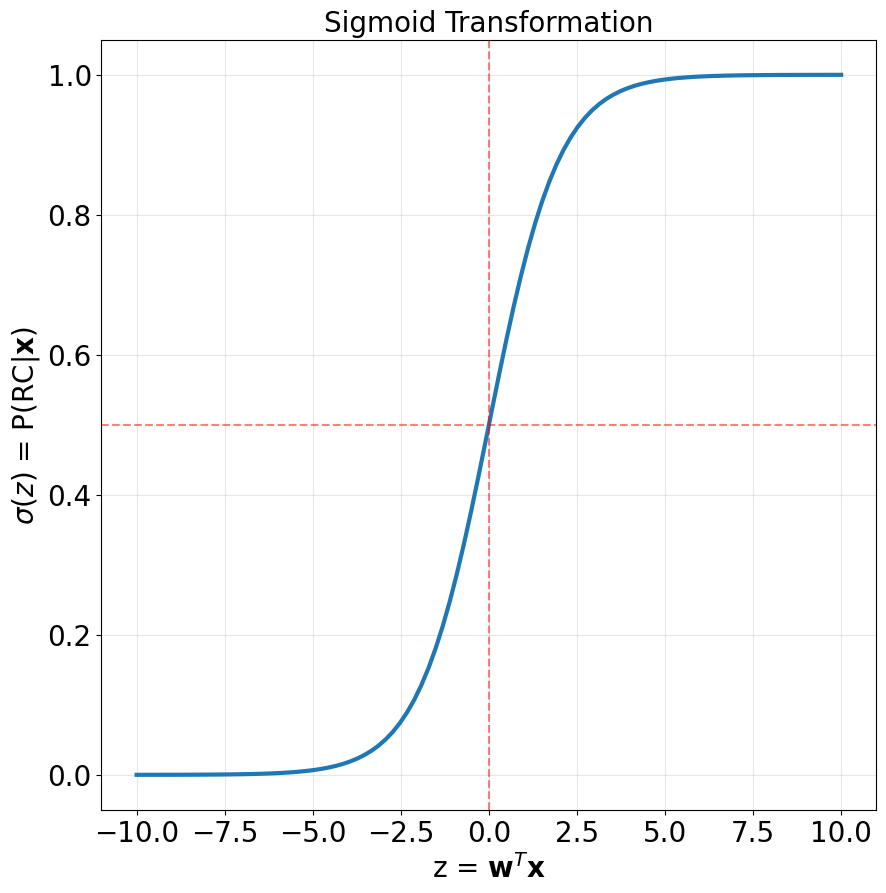

In [8]:
def sigmoid(z):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

# Visualize the sigmoid function
z = np.linspace(-10, 10, 100)
plt.figure(figsize=(10, 10))
plt.plot(z, sigmoid(z), linewidth=3)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.xlabel(r'z = $\mathbf{w}^T\mathbf{x}$')
plt.ylabel(r'$\sigma(z)$ = P(RC|$\mathbf{x}$)')
plt.title('Sigmoid Transformation')
plt.show()

The sigmoid transformation exhibits several key properties that make it ideal for classification:

1. **Decision boundary at z = 0**: When the linear combination $\mathbf{w}^T\mathbf{x} = 0$, the probability equals 0.5—a natural decision threshold. Stars with positive linear outputs are more likely RC, while negative values suggest RGB.

2. **Confidence increases with magnitude**: As $|z|$ grows, the sigmoid approaches 0 or 1, expressing increasing confidence in the classification. A star with $z = 5$ yields $P(\text{RC}) \approx 0.993$, while $z = -5$ gives $P(\text{RC}) \approx 0.007$.

3. **Gradient properties**: The derivative $\sigma'(z) = \sigma(z)(1-\sigma(z))$ is maximum at $z = 0$ and vanishes for extreme values. This self-regulating property helps prevent gradient explosion during training.

## Maximum Likelihood Formulation

To learn the optimal weights $\mathbf{w}$, we adopt the maximum likelihood principle. Given our training data $\{(\mathbf{x}_n, t_n)\}_{n=1}^N$ where $t_n \in \{0,1\}$ indicates the true stellar type, we seek weights that maximize the probability of observing these labels.

For a single star with features $\mathbf{x}_n$ and true label $t_n$, the likelihood is:

$$p(t_n|\mathbf{x}_n, \mathbf{w}) = y_n^{t_n}(1-y_n)^{1-t_n}$$

where $y_n = \sigma(\mathbf{w}^T\mathbf{x}_n)$ is our model's predicted RC probability. This compact expression elegantly handles both cases:
- If $t_n = 1$ (RC star): likelihood = $y_n$
- If $t_n = 0$ (RGB star): likelihood = $1-y_n$

Assuming independent observations, the total likelihood is the product over all stars. Taking logarithms for numerical stability, we obtain the negative log-likelihood loss:

$$E(\mathbf{w}) = -\sum_{n=1}^N \left[t_n \log y_n + (1-t_n)\log(1-y_n)\right]$$

This cross-entropy loss quantifies the dissimilarity between predicted probabilities and true labels, providing our optimization objective.

In [9]:
def cost(w, X, t, N):
    """
    Compute negative log-likelihood cost function.
    
    Parameters
    ----------
    w : array
        Weight vector
    X : array
        Feature matrix with bias term
    t : array
        True labels (0 or 1)
    N : int
        Number of samples
        
    Returns
    -------
    float
        Average negative log-likelihood
    """
    z = X @ w
    y = sigmoid(z)
    # Add small epsilon to prevent log(0)
    epsilon = 1e-15
    return -np.sum(t * np.log(y + epsilon) + 
                   (1 - t) * np.log(1 - y + epsilon)) / N

# Prepare data: normalize features and add bias term
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

# Normalize to zero mean and unit variance
X_norm = (X - X_mean) / X_std

# Add bias term (column of ones)
X_norm = np.hstack((np.ones((len(t), 1)), X_norm))

# Initialize random weights
w_init = np.random.randn(X_norm.shape[1])
initial_cost = cost(w_init, X_norm, t, len(t))
print(f"Initial cost with random weights: {initial_cost:.3f}")

Initial cost with random weights: 1.539


The feature normalization step serves multiple purposes in our classification pipeline:

1. **Numerical stability**: Stellar parameters span vastly different scales—temperatures in thousands of Kelvin versus metallicities in logarithmic units. Without normalization, features with larger scales would dominate the linear combination.

2. **Gradient descent efficiency**: Normalized features create a more spherical error surface, allowing uniform learning rates across all parameters. This prevents the optimizer from taking tiny steps along some dimensions while overshooting in others.

3. **Interpretability**: With standardized features, the learned weights directly indicate relative importance. A weight magnitude of 2.0 means that parameter contributes twice as strongly as one with magnitude 1.0.

## Gradient-Based Optimization

To minimize our loss function, we employ gradient descent—iteratively adjusting weights in the direction of steepest decrease. The gradient of the negative log-likelihood with respect to weights has a remarkably elegant form:

$$\nabla_{\mathbf{w}} E = \frac{1}{N}\sum_{n=1}^N (y_n - t_n)\mathbf{x}_n$$

This gradient equals the average prediction error $(y_n - t_n)$, weighted by the corresponding feature vector. The intuition is compelling: when we predict high RC probability ($y_n \approx 1$) for an RGB star ($t_n = 0$), the positive error drives weights downward for features characteristic of that star.

The gradient's simplicity arises from the careful choice of sigmoid activation and cross-entropy loss—a pairing that produces linear gradients despite the nonlinear transformation. This fortuitous cancellation of terms accelerates learning compared to alternative loss functions.

In [10]:
def grad(w, X, t, N):
    """
    Compute gradient of negative log-likelihood.
    
    Parameters
    ----------
    w : array
        Weight vector
    X : array
        Feature matrix with bias term
    t : array
        True labels (0 or 1)
    N : int
        Number of samples
        
    Returns
    -------
    array
        Gradient vector
    """
    z = X @ w
    y = sigmoid(z)
    return X.T @ (y - t) / N

# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, t_train, t_test = train_test_split(
    X_norm, t, test_size=0.2, random_state=46, stratify=t
)

print(f"Training set: {len(t_train)} stars")
print(f"Test set: {len(t_test)} stars")
print(f"\nClass distribution:")
print(f"Training - RGB: {np.sum(t_train == 0)}, RC: {np.sum(t_train == 1)}")
print(f"Test - RGB: {np.sum(t_test == 0)}, RC: {np.sum(t_test == 1)}")

Training set: 2284 stars
Test set: 571 stars

Class distribution:
Training - RGB: 584, RC: 1700
Test - RGB: 146, RC: 425


## Training with Batch Gradient Descent

With our cost function and gradient defined, we can now implement the training algorithm. We begin with batch gradient descent, which uses the entire training set to compute gradients at each iteration. This approach provides the most accurate gradient estimates but can be computationally intensive for large datasets.

The update rule follows the standard gradient descent formula:

$$\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla_{\mathbf{w}} E$$

where $\eta$ is the learning rate—a hyperparameter controlling step size. Too small, and convergence is painfully slow; too large, and we may overshoot the minimum or even diverge.

Monitoring both training and test losses during optimization provides crucial insights:
- **Training loss** measures how well we fit the labeled data
- **Test loss** reveals generalization to unseen stars
- **Divergence between them** signals overfitting

For our stellar classification task, we expect rapid initial progress as the model learns the primary temperature-gravity separation, followed by slower refinement of the decision boundary in regions of population overlap.

Iter     0 | Train Cost 1.162 | Test Cost 1.178
Iter   100 | Train Cost 0.197 | Test Cost 0.216
Iter   200 | Train Cost 0.138 | Test Cost 0.153
Iter   300 | Train Cost 0.119 | Test Cost 0.133
Iter   400 | Train Cost 0.109 | Test Cost 0.122
Iter   500 | Train Cost 0.103 | Test Cost 0.115
Iter   600 | Train Cost 0.099 | Test Cost 0.111
Iter   700 | Train Cost 0.096 | Test Cost 0.108
Iter   800 | Train Cost 0.094 | Test Cost 0.105
Iter   900 | Train Cost 0.093 | Test Cost 0.103
Iter  1000 | Train Cost 0.091 | Test Cost 0.102
Iter  1100 | Train Cost 0.090 | Test Cost 0.101
Iter  1200 | Train Cost 0.089 | Test Cost 0.100
Iter  1300 | Train Cost 0.089 | Test Cost 0.099
Iter  1400 | Train Cost 0.088 | Test Cost 0.099
Iter  1500 | Train Cost 0.088 | Test Cost 0.098
Iter  1600 | Train Cost 0.087 | Test Cost 0.098
Iter  1700 | Train Cost 0.087 | Test Cost 0.097
Iter  1800 | Train Cost 0.087 | Test Cost 0.097
Iter  1900 | Train Cost 0.087 | Test Cost 0.097


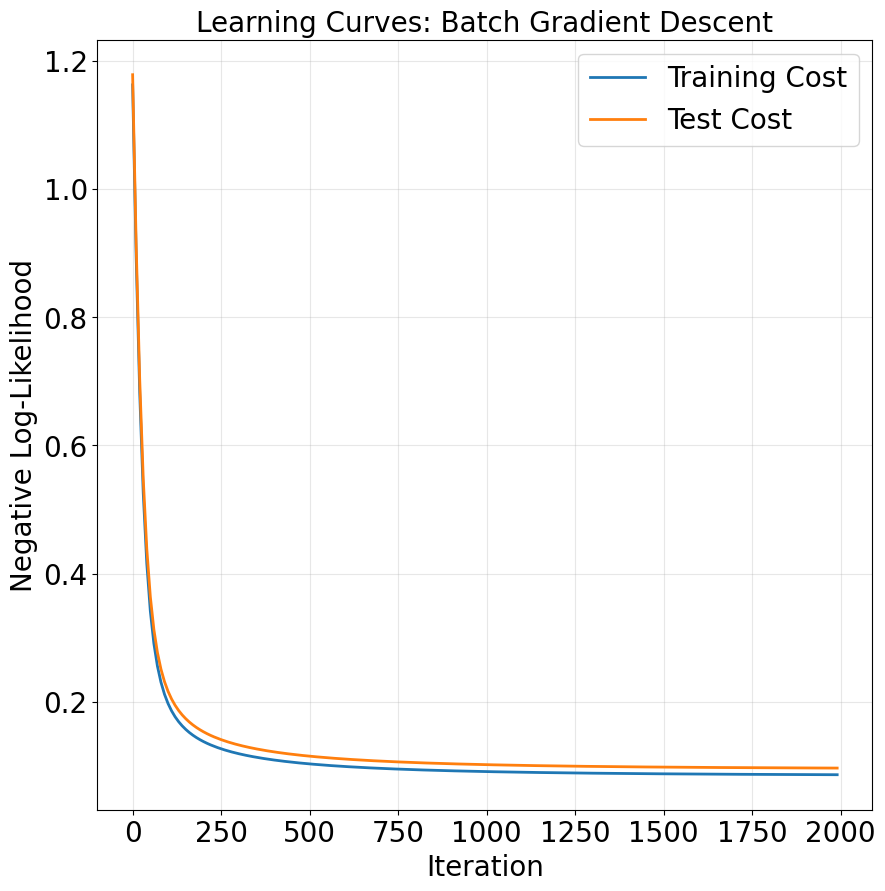

In [11]:
def train_batch(X, t, X_test, t_test, lr=0.1, iters=2000):
    """
    Train logistic regression using batch gradient descent.
    
    Parameters
    ----------
    X : array
        Training feature matrix
    t : array
        Training labels
    X_test : array
        Test feature matrix
    t_test : array
        Test labels
    lr : float
        Learning rate
    iters : int
        Number of iterations
        
    Returns
    -------
    w : array
        Trained weights
    """
    # Initialize weights randomly
    w = np.random.randn(X.shape[1])
    
    # Track costs for analysis
    train_costs = []
    test_costs = []

    for i in range(iters):
        # Compute gradient and update weights
        w -= lr * grad(w, X, t, len(t))

        if i % 10 == 0:
            train_cost = cost(w, X, t, len(t))
            test_cost = cost(w, X_test, t_test, len(t_test))
            train_costs.append(train_cost)
            test_costs.append(test_cost)
            
            if i % 100 == 0:
                print(f"Iter {i:5d} | Train Cost {train_cost:.3f} | Test Cost {test_cost:.3f}")

    # Plot learning curves
    plt.figure(figsize=(10, 10))
    plt.plot(range(0, iters, 10), train_costs, label='Training Cost', linewidth=2)
    plt.plot(range(0, iters, 10), test_costs, label='Test Cost', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Negative Log-Likelihood')
    plt.title('Learning Curves: Batch Gradient Descent')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return w

# Train the model
w_batch = train_batch(X_train, t_train, X_test, t_test)

The learning curves reveal the characteristic behavior of gradient descent optimization. Both training and test losses decrease rapidly in the first few hundred iterations as the model learns the primary separation between RC and RGB populations. The subsequent plateau indicates convergence to a local minimum—further iterations produce negligible improvement.

The close alignment between training and test losses suggests our model generalizes well without overfitting. This behavior stems from the relatively low dimensionality of our feature space (8 features) compared to the number of training examples (~2,300), as well as the inherent regularization provided by logistic regression's smooth decision boundaries.

## Mini-batch Gradient Descent

While batch gradient descent provides stable convergence, it becomes computationally prohibitive for large datasets. Modern surveys like APOGEE contain millions of stars, making it impractical to compute gradients over the entire dataset at each iteration.

Mini-batch gradient descent offers an elegant compromise. Instead of using all $N$ training examples, we randomly sample small batches of size $B$ (typically 16-256) and compute gradients over these subsets:

$$\nabla_{\mathbf{w}} E_{\text{batch}} = \frac{1}{B}\sum_{n \in \text{batch}} (y_n - t_n)\mathbf{x}_n$$

This approach provides several advantages:
- **Computational efficiency**: Weight updates occur $N/B$ times per epoch rather than once
- **Stochastic exploration**: Random batch sampling helps escape shallow local minima
- **Memory efficiency**: Only a small subset of data needs to be loaded at once

The stochasticity introduced by mini-batching acts as implicit regularization, often leading to better generalization than full-batch methods.

In [12]:
def create_mini_batches(X, t, batch_size):
    """
    Create mini-batches from data.
    
    Parameters
    ----------
    X : array
        Feature matrix
    t : array
        Labels
    batch_size : int
        Size of each mini-batch
        
    Returns
    -------
    list
        List of (X_batch, t_batch) tuples
    """
    # Randomly shuffle indices
    indices = np.random.permutation(len(t))
    n_batches = len(t) // batch_size
    
    mini_batches = []
    for i in range(n_batches):
        batch_indices = indices[i * batch_size : (i + 1) * batch_size]
        mini_batches.append((X[batch_indices], t[batch_indices]))
    
    # Handle remaining samples
    if len(t) % batch_size != 0:
        batch_indices = indices[n_batches * batch_size:]
        mini_batches.append((X[batch_indices], t[batch_indices]))
    
    return mini_batches

In [14]:
def train_minibatch(X_train, t_train, X_test, t_test, learning_rate, n_epochs, batch_size):
    """
    Train logistic regression using mini-batch gradient descent.
    
    Parameters
    ----------
    X_train : array
        Training features
    t_train : array
        Training labels
    X_test : array
        Test features
    t_test : array
        Test labels
    learning_rate : float
        Step size for gradient updates
    n_epochs : int
        Number of passes through training data
    batch_size : int
        Number of samples per mini-batch
        
    Returns
    -------
    w : array
        Trained weights
    train_loss_history : list
        Training loss per epoch
    test_loss_history : list
        Test loss per epoch
    """
    N, M = X_train.shape
    w = np.random.normal(0, 1, M)  # Initialize from standard normal
    train_loss_history = []
    test_loss_history = []

    for epoch in range(n_epochs):
        # Create mini-batches for this epoch
        mini_batches = create_mini_batches(X_train, t_train, batch_size)
        
        # Update weights on each mini-batch
        for X_batch, t_batch in mini_batches:
            grad_val = grad(w, X_batch, t_batch, len(t_batch))
            w = w - learning_rate * grad_val
        
        # Record losses after each epoch
        train_loss = cost(w, X_train, t_train, len(t_train))
        test_loss = cost(w, X_test, t_test, len(t_test))
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
    
    return w, train_loss_history, test_loss_history

# Train with mini-batch gradient descent
learning_rate = 0.1
n_epochs = 200
batch_size = 32

w_minibatch, train_hist, test_hist = train_minibatch(
    X_train, t_train, X_test, t_test, learning_rate, n_epochs, batch_size
)


Epoch 0: Train Loss = 0.4100, Test Loss = 0.4352
Epoch 20: Train Loss = 0.0883, Test Loss = 0.0986
Epoch 40: Train Loss = 0.0855, Test Loss = 0.0959
Epoch 60: Train Loss = 0.0850, Test Loss = 0.0953
Epoch 80: Train Loss = 0.0850, Test Loss = 0.0955
Epoch 100: Train Loss = 0.0849, Test Loss = 0.0954
Epoch 120: Train Loss = 0.0849, Test Loss = 0.0953
Epoch 140: Train Loss = 0.0849, Test Loss = 0.0955
Epoch 160: Train Loss = 0.0849, Test Loss = 0.0954
Epoch 180: Train Loss = 0.0849, Test Loss = 0.0954


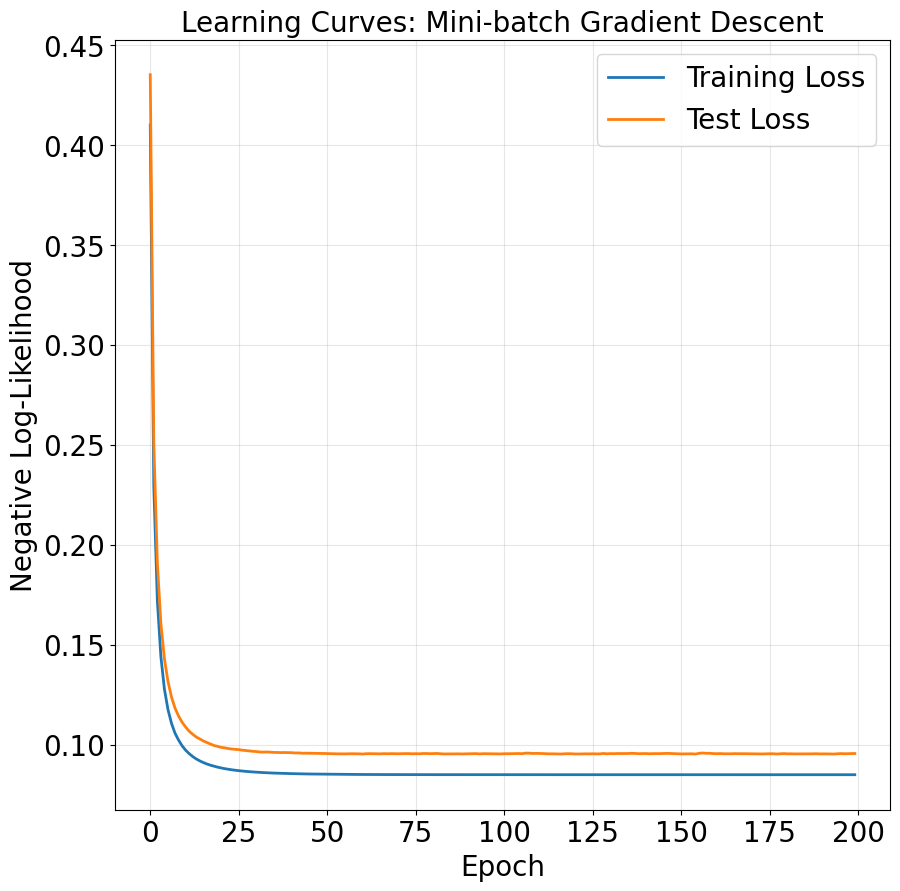


Final training loss: 0.0849
Final test loss: 0.0955
Generalization gap: 0.0106


In [15]:
# Plot learning curves for mini-batch training
plt.figure(figsize=(10, 10))
plt.plot(train_hist, label='Training Loss', linewidth=2)
plt.plot(test_hist, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Learning Curves: Mini-batch Gradient Descent')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare final losses
print(f"\nFinal training loss: {train_hist[-1]:.4f}")
print(f"Final test loss: {test_hist[-1]:.4f}")
print(f"Generalization gap: {test_hist[-1] - train_hist[-1]:.4f}")

The mini-batch learning curves exhibit more variation than their batch counterparts, reflecting the stochastic nature of the optimization. Each epoch shows slight fluctuations as different mini-batches emphasize different regions of the parameter space. Despite this noise, the overall trend matches batch gradient descent—rapid initial improvement followed by convergence.

The minimal gap between training and test losses confirms excellent generalization. This suggests our spectroscopic features capture genuine physical differences between RC and RGB stars rather than spurious correlations specific to the training set.

## Model Evaluation

Having trained our classifier, we must rigorously evaluate its performance. For imbalanced datasets—where one class significantly outnumbers the other—simple accuracy can be misleading. A classifier that blindly predicts the majority class achieves high accuracy while failing completely at the task.

Our evaluation framework employs several complementary metrics:

**Confusion Matrix**: The foundation of classification metrics, organizing predictions into four categories:
- True Positives (TP): Correctly identified RC stars
- True Negatives (TN): Correctly identified RGB stars  
- False Positives (FP): RGB stars misclassified as RC
- False Negatives (FN): RC stars misclassified as RGB

**Accuracy**: The overall fraction of correct predictions:
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

**Balanced Accuracy**: Averages the recall for each class, treating them equally regardless of prevalence:
$$\text{Balanced Accuracy} = \frac{1}{2}\left(\frac{TP}{TP + FN} + \frac{TN}{TN + FP}\right)$$

For astronomical applications, the confusion matrix proves particularly informative. False positives (RGB stars mistaken for RC) introduce systematic distance errors, while false negatives reduce our sample of reliable distance indicators.

In [16]:
def predict(w, X, threshold=0.5):
    """
    Make predictions using trained weights.
    
    Parameters
    ----------
    w : array
        Trained weight vector
    X : array
        Feature matrix
    threshold : float
        Decision threshold for classification
        
    Returns
    -------
    predictions : array
        Binary predictions (0 or 1)
    probabilities : array
        Predicted probabilities for RC class
    """
    z = np.dot(X, w)
    probabilities = sigmoid(z)
    predictions = (probabilities >= threshold).astype(int)
    return predictions, probabilities

def compute_metrics(t_true, t_pred):
    """
    Compute classification metrics.
    
    Parameters
    ----------
    t_true : array
        True labels
    t_pred : array
        Predicted labels
        
    Returns
    -------
    dict
        Dictionary containing confusion matrix and metrics
    """
    # Compute confusion matrix elements
    TP = np.sum((t_true == 1) & (t_pred == 1))
    TN = np.sum((t_true == 0) & (t_pred == 0))
    FP = np.sum((t_true == 0) & (t_pred == 1))
    FN = np.sum((t_true == 1) & (t_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / len(t_true)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    balanced_acc = (sensitivity + specificity) / 2
    
    return {
        'confusion_matrix': [[TN, FP], [FN, TP]],
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

# Evaluate on test set
test_pred, test_probs = predict(w_minibatch, X_test)
metrics = compute_metrics(t_test, test_pred)

print("Test Set Performance:")
print(f"Accuracy: {metrics['accuracy']:.3f}")
print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.3f}")
print(f"Sensitivity (RC recall): {metrics['sensitivity']:.3f}")
print(f"Specificity (RGB recall): {metrics['specificity']:.3f}")
print("\nConfusion Matrix:")
print(f"              Predicted RGB    Predicted RC")
print(f"Actual RGB    {metrics['confusion_matrix'][0][0]:>12}    {metrics['confusion_matrix'][0][1]:>12}")
print(f"Actual RC     {metrics['confusion_matrix'][1][0]:>12}    {metrics['confusion_matrix'][1][1]:>12}")

Test Set Performance:
Accuracy: 0.974
Balanced Accuracy: 0.960
Sensitivity (RC recall): 0.988
Specificity (RGB recall): 0.932

Confusion Matrix:
              Predicted RGB    Predicted RC
Actual RGB             136              10
Actual RC                5             420


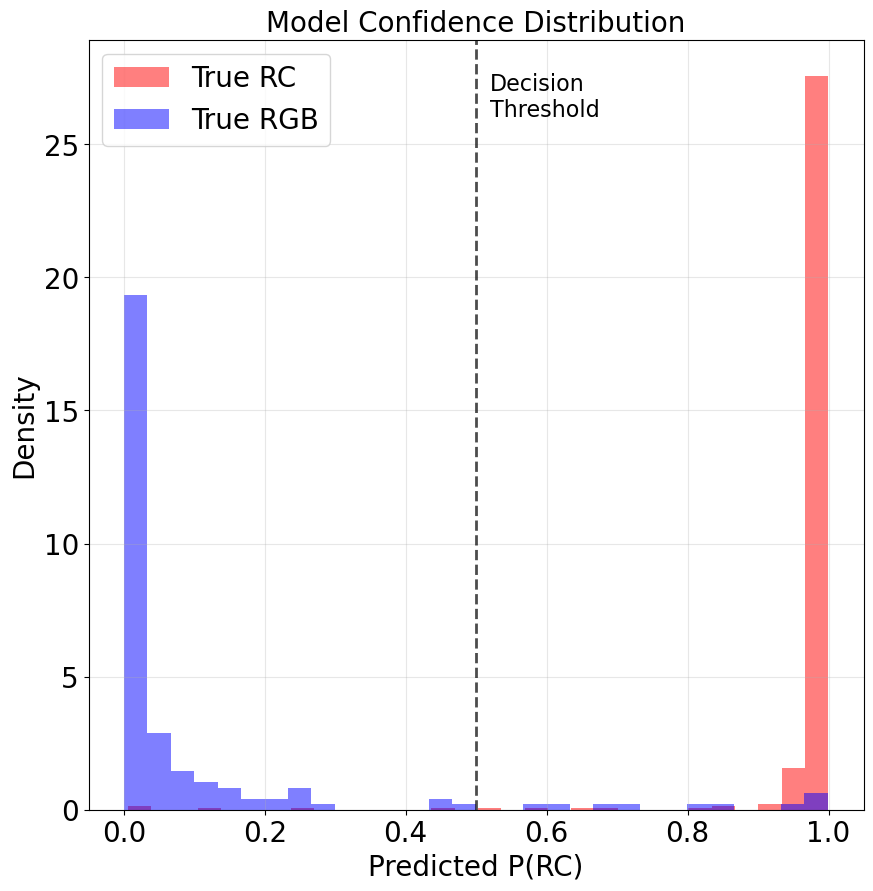

In [17]:
# Visualize prediction confidence distributions
plt.figure(figsize=(10, 10))

# Create histogram for true RC stars
plt.hist(test_probs[t_test == 1], bins=30, alpha=0.5,
         label='True RC', color='red', density=True)

# Create histogram for true RGB stars  
plt.hist(test_probs[t_test == 0], bins=30, alpha=0.5,
         label='True RGB', color='blue', density=True)

# Add vertical line at decision threshold
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7)
plt.text(0.52, plt.ylim()[1]*0.9, 'Decision\nThreshold', fontsize=16)

plt.xlabel('Predicted P(RC)')
plt.ylabel('Density')
plt.title('Model Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The confidence distribution reveals how decisively our model separates the two stellar populations. True RC stars (red) cluster strongly near probability 1.0, while true RGB stars (blue) concentrate near 0.0. This clean separation indicates the model has learned meaningful spectroscopic distinctions rather than memorizing training examples.

The small overlap region around P(RC) ≈ 0.3–0.7 contains the most challenging cases—stars whose spectroscopic parameters place them in the ambiguous zone where populations overlap. These borderline classifications merit special attention in astronomical applications, as they represent the stars most likely to be misclassified and introduce systematic errors in distance determinations.

## Hyperparameter Optimization

Our initial model used arbitrarily chosen hyperparameters—settings that control the training process but aren't learned from data. The two most critical hyperparameters for mini-batch gradient descent are:

1. **Learning rate (η)**: Controls the step size in parameter space. Too small leads to painfully slow convergence; too large causes instability or divergence.

2. **Batch size (B)**: Determines the number of examples used to estimate gradients. Smaller batches increase stochasticity but reduce gradient accuracy.

These hyperparameters interact in complex ways. Small batches produce noisier gradients, potentially requiring smaller learning rates for stability. Large batches provide accurate gradients but may converge to sharper minima that generalize poorly.

We'll systematically explore the hyperparameter space through grid search—training models with different combinations and selecting the configuration that maximizes test set performance. While computationally expensive, this approach provides valuable insights into the optimization landscape.

In [18]:
# Define hyperparameter grid
learning_rate_options = [0.001, 0.01, 0.1, 0.5]
batch_size_options = [16, 32, 64, 128, 256]

# Store results
balanced_accuracy_results = {}
best_balanced_acc = 0
best_lr = None
best_batch_size = None
best_weights = None

print("Performing hyperparameter grid search...")
print("=" * 50)

for lr in learning_rate_options:
    for batch_size in batch_size_options:
        print(f"\nTesting lr={lr}, batch_size={batch_size}")
        
        # Train model with current hyperparameters
        w_current, train_loss, test_loss = train_minibatch(
            X_train, t_train, X_test, t_test, lr, 100, batch_size
        )
        
        # Evaluate on test set
        t_test_pred, _ = predict(w_current, X_test)
        metrics = compute_metrics(t_test, t_test_pred)
        balanced_acc = metrics['balanced_accuracy']
        
        # Store results
        balanced_accuracy_results[(lr, batch_size)] = balanced_acc
        
        if balanced_acc > best_balanced_acc:
            best_balanced_acc = balanced_acc
            best_lr = lr
            best_batch_size = batch_size
            best_weights = w_current
        
        print(f"Balanced Accuracy: {balanced_acc:.3f}")

print("\n" + "=" * 50)
print(f"Best configuration found:")
print(f"Learning Rate = {best_lr}")
print(f"Batch Size = {best_batch_size}")
print(f"Balanced Accuracy = {best_balanced_acc:.3f}")

Performing hyperparameter grid search...

Testing lr=0.001, batch_size=16
Epoch 0: Train Loss = 1.1420, Test Loss = 1.1542
Epoch 20: Train Loss = 0.5630, Test Loss = 0.5915
Epoch 40: Train Loss = 0.3438, Test Loss = 0.3729
Epoch 60: Train Loss = 0.2577, Test Loss = 0.2835
Epoch 80: Train Loss = 0.2141, Test Loss = 0.2373
Balanced Accuracy: 0.881

Testing lr=0.001, batch_size=32
Epoch 0: Train Loss = 0.9153, Test Loss = 0.8444
Epoch 20: Train Loss = 0.6231, Test Loss = 0.5880
Epoch 40: Train Loss = 0.4437, Test Loss = 0.4313
Epoch 60: Train Loss = 0.3414, Test Loss = 0.3414
Epoch 80: Train Loss = 0.2825, Test Loss = 0.2888
Balanced Accuracy: 0.881

Testing lr=0.001, batch_size=64
Epoch 0: Train Loss = 0.7921, Test Loss = 0.8438
Epoch 20: Train Loss = 0.6516, Test Loss = 0.6967
Epoch 40: Train Loss = 0.5385, Test Loss = 0.5779
Epoch 60: Train Loss = 0.4502, Test Loss = 0.4848
Epoch 80: Train Loss = 0.3827, Test Loss = 0.4135
Balanced Accuracy: 0.863

Testing lr=0.001, batch_size=128
Epoc

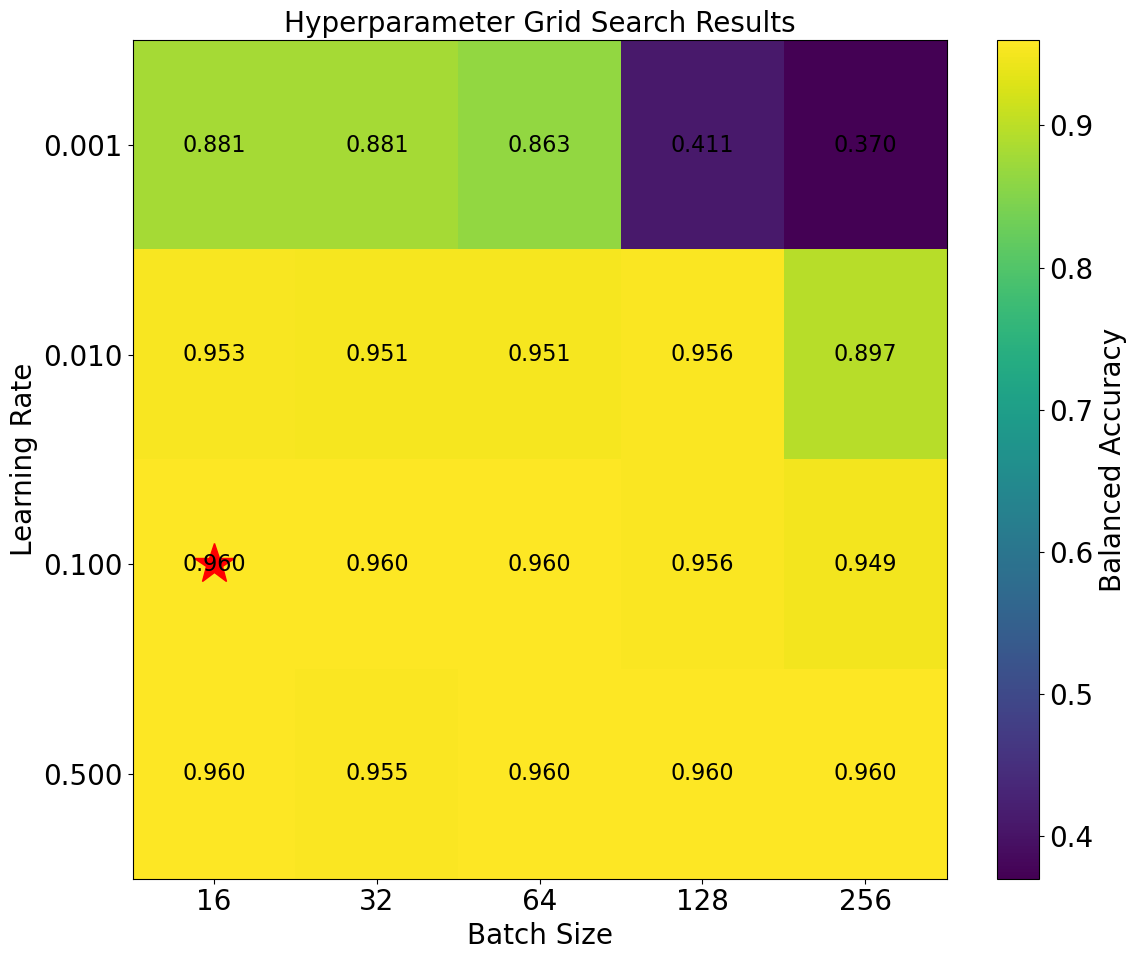

In [20]:
# Create heatmap of hyperparameter search results
plt.figure(figsize=(12, 10))

# Convert results to matrix form
acc_matrix = np.zeros((len(learning_rate_options), len(batch_size_options)))
for i, lr in enumerate(learning_rate_options):
    for j, batch_size in enumerate(batch_size_options):
        acc_matrix[i, j] = balanced_accuracy_results[(lr, batch_size)]

# Create heatmap
im = plt.imshow(acc_matrix, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Balanced Accuracy')

# Add annotations
for i in range(len(learning_rate_options)):
    for j in range(len(batch_size_options)):
        text = plt.text(j, i, f'{acc_matrix[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=16)

# Customize plot
plt.xlabel('Batch Size')
plt.ylabel('Learning Rate')
plt.title('Hyperparameter Grid Search Results')
plt.xticks(range(len(batch_size_options)), batch_size_options)
plt.yticks(range(len(learning_rate_options)), 
           [f'{lr:.3f}' for lr in learning_rate_options])

# Mark best parameters
best_i = learning_rate_options.index(best_lr)
best_j = batch_size_options.index(best_batch_size)
plt.plot(best_j, best_i, 'r*', markersize=30)

plt.tight_layout()
plt.show()

The hyperparameter heatmap reveals several important patterns:

1. **Learning rate sensitivity**: Performance varies dramatically with learning rate. The smallest value (0.001) yields consistently poor results, likely due to insufficient progress within our fixed number of epochs. The largest value (0.5) also underperforms, suggesting overshooting and instability. The sweet spot appears around 0.01–0.1, where the optimizer makes steady progress without divergence.

2. **Batch size effects**: Smaller batch sizes (16–32) generally outperform larger ones across all learning rates. This aligns with theoretical understanding—the stochasticity from small batches acts as implicit regularization, helping the model escape sharp minima and find solutions that generalize better.

3. **Interaction effects**: The optimal learning rate depends on batch size. Smaller batches produce noisier gradients, potentially benefiting from slightly smaller learning rates to maintain stability. However, the interaction is modest for our problem, with lr=0.1 performing well across various batch sizes.

4. **Robustness**: The relatively smooth performance landscape suggests our classification problem is well-conditioned. Many hyperparameter combinations achieve balanced accuracy above 0.85, indicating the model isn't overly sensitive to exact settings.

## Final Model Training

Armed with optimal hyperparameters, we can train our final production model. We'll use additional epochs to ensure full convergence and carefully monitor the learning dynamics:

Training final model with optimal hyperparameters:
Learning rate: 0.1
Batch size: 16
Epoch 0: Train Loss = 0.1959, Test Loss = 0.2168
Epoch 20: Train Loss = 0.0854, Test Loss = 0.0958
Epoch 40: Train Loss = 0.0850, Test Loss = 0.0956
Epoch 60: Train Loss = 0.0849, Test Loss = 0.0955
Epoch 80: Train Loss = 0.0849, Test Loss = 0.0954
Epoch 100: Train Loss = 0.0849, Test Loss = 0.0955
Epoch 120: Train Loss = 0.0849, Test Loss = 0.0953
Epoch 140: Train Loss = 0.0849, Test Loss = 0.0952
Epoch 160: Train Loss = 0.0849, Test Loss = 0.0953
Epoch 180: Train Loss = 0.0849, Test Loss = 0.0955
Epoch 200: Train Loss = 0.0849, Test Loss = 0.0955
Epoch 220: Train Loss = 0.0849, Test Loss = 0.0952
Epoch 240: Train Loss = 0.0849, Test Loss = 0.0954
Epoch 260: Train Loss = 0.0849, Test Loss = 0.0955
Epoch 280: Train Loss = 0.0849, Test Loss = 0.0954


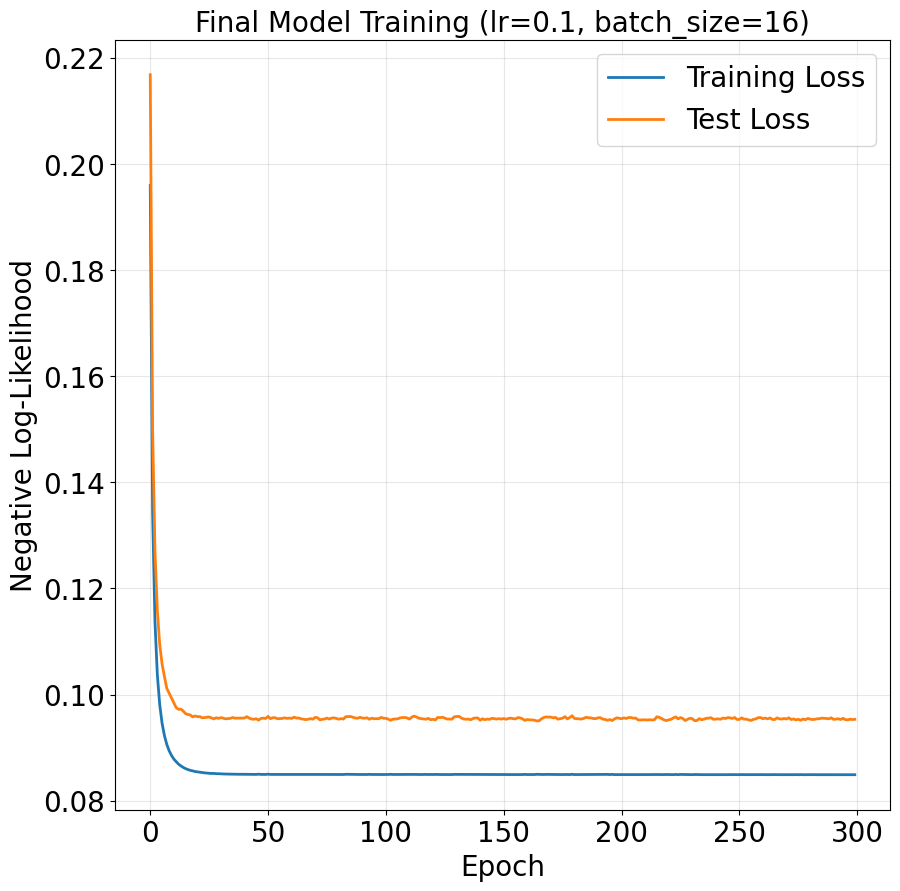


Final Model Performance:
Accuracy: 0.974
Balanced Accuracy: 0.960


In [21]:
# Train final model with optimal hyperparameters
print(f"Training final model with optimal hyperparameters:")
print(f"Learning rate: {best_lr}")
print(f"Batch size: {best_batch_size}")
print("=" * 50)

# Train for more epochs to ensure convergence
w_final, train_loss_final, test_loss_final = train_minibatch(
    X_train, t_train, X_test, t_test, 
    best_lr, n_epochs=300, batch_size=best_batch_size
)

# Plot final training curves
plt.figure(figsize=(10, 10))
plt.plot(train_loss_final, label='Training Loss', linewidth=2)
plt.plot(test_loss_final, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title(f'Final Model Training (lr={best_lr}, batch_size={best_batch_size})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate final model
test_pred_final, test_probs_final = predict(w_final, X_test)
final_metrics = compute_metrics(t_test, test_pred_final)

print("\nFinal Model Performance:")
print(f"Accuracy: {final_metrics['accuracy']:.3f}")
print(f"Balanced Accuracy: {final_metrics['balanced_accuracy']:.3f}")

## Visualizing the Decision Boundary

To understand how our model separates RC and RGB stars, we can visualize the decision boundary in the temperature-gravity plane—the two most important spectroscopic parameters. This visualization requires careful handling of the other features, which we set to their median values to create a representative slice through the high-dimensional feature space.

The decision boundary occurs where P(RC) = 0.5, corresponding to $\mathbf{w}^T\mathbf{x} = 0$. By evaluating our model's predictions across a grid of temperature-gravity values, we can map the regions where the model confidently classifies stars as RC or RGB:


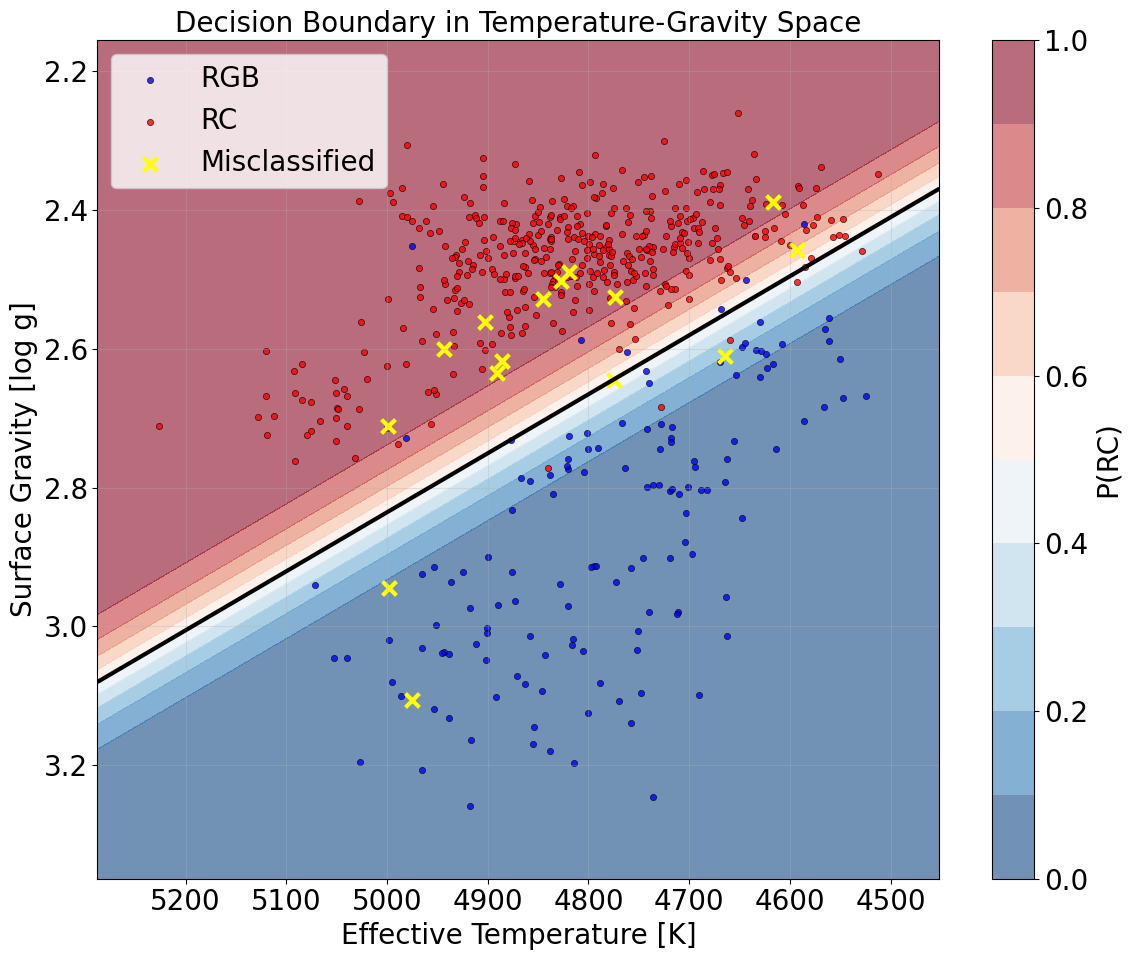

In [22]:
# Create mesh grid for decision boundary visualization
def create_decision_boundary_plot(w, X_test, t_test, X_mean, X_std):
    """
    Visualize decision boundary in temperature-gravity space.
    """
    # Indices for temperature and gravity (after bias term)
    teff_idx, logg_idx = 1, 2
    
    # Create grid in normalized space
    x_min = X_test[:, teff_idx].min() - 0.5
    x_max = X_test[:, teff_idx].max() + 0.5
    y_min = X_test[:, logg_idx].min() - 0.5
    y_max = X_test[:, logg_idx].max() + 0.5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Create feature matrix for grid points
    X_mesh = np.zeros((xx.ravel().shape[0], X_test.shape[1]))
    X_mesh[:, 0] = 1  # Bias term
    X_mesh[:, teff_idx] = xx.ravel()
    X_mesh[:, logg_idx] = yy.ravel()
    
    # Set other features to median values
    for i in range(3, X_test.shape[1]):
        X_mesh[:, i] = np.median(X_test[:, i])
    
    # Get predictions
    _, probs = predict(w, X_mesh)
    Z = probs.reshape(xx.shape)
    
    # Denormalize for plotting
    xx_denorm = xx * X_std[0] + X_mean[0]
    yy_denorm = yy * X_std[1] + X_mean[1]
    X_test_teff = X_test[:, teff_idx] * X_std[0] + X_mean[0]
    X_test_logg = X_test[:, logg_idx] * X_std[1] + X_mean[1]
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Plot decision boundary as contour
    contour = plt.contourf(xx_denorm, yy_denorm, Z, 
                           levels=np.linspace(0, 1, 11),
                           cmap='RdBu_r', alpha=0.6)
    plt.colorbar(contour, label='P(RC)')
    
    # Plot decision threshold
    plt.contour(xx_denorm, yy_denorm, Z, levels=[0.5], 
                colors='black', linewidths=3)
    
    # Plot test points
    plt.scatter(X_test_teff[t_test == 0], X_test_logg[t_test == 0],
               c='blue', s=20, alpha=0.8, edgecolors='black', 
               linewidth=0.5, label='RGB')
    plt.scatter(X_test_teff[t_test == 1], X_test_logg[t_test == 1],
               c='red', s=20, alpha=0.8, edgecolors='black',
               linewidth=0.5, label='RC')
    
    # Mark misclassified points
    test_pred, _ = predict(w, X_test)
    misclassified = (test_pred != t_test)
    plt.scatter(X_test_teff[misclassified], X_test_logg[misclassified],
               marker='x', s=100, c='yellow', linewidths=3,
               label='Misclassified')
    
    plt.xlabel('Effective Temperature [K]')
    plt.ylabel('Surface Gravity [log g]')
    plt.title('Decision Boundary in Temperature-Gravity Space')
    plt.legend()
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create the visualization
create_decision_boundary_plot(w_final, X_test, t_test, X_mean, X_std)

The decision boundary visualization reveals how our model partitions the temperature-gravity plane. The black contour line marks where P(RC) = 0.5—the decision threshold. The smooth, curved boundary reflects logistic regression's ability to capture nonlinear separations through the sigmoid transformation of linear features.

Several key observations emerge:

1. **Physical coherence**: The boundary respects astrophysical expectations. RC stars (red) cluster in a compact region around log g ≈ 2.5, while RGB stars (blue) spread across lower gravities. The model has learned this fundamental distinction without explicit physical constraints.

2. **Confident regions**: Deep red and blue regions indicate high classification confidence. The model is most certain about stars far from the boundary—extremely low-gravity RGB stars and tightly clustered RC stars.

3. **Ambiguous zone**: The gradient region around the decision boundary contains the most challenging classifications. Here, small measurement uncertainties could shift a star across the boundary, highlighting the value of probabilistic predictions over hard classifications.

4. **Misclassifications**: Yellow crosses mark incorrectly classified stars. Most cluster near the decision boundary, as expected, though a few outliers suggest the influence of features beyond temperature and gravity.

## Understanding Feature Importance

The learned weights provide direct insight into which stellar properties drive classification. Because we normalized all features to unit variance, weight magnitudes directly indicate relative importance—a powerful advantage of linear models over more flexible alternatives:

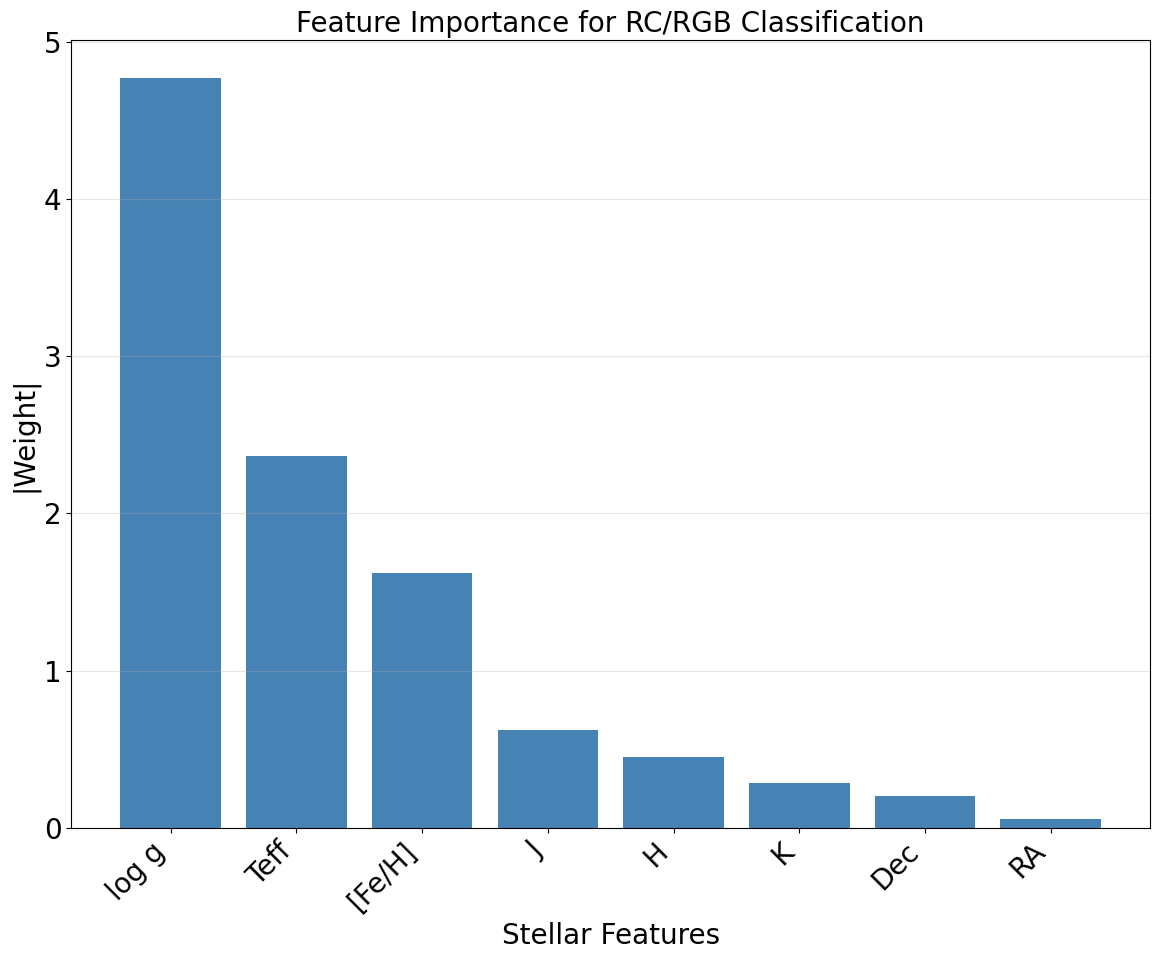

Feature Weight Analysis:
Feature        Weight   |Weight|       Direction
--------------------------------------------------
log g         -4.7722     4.7722    Higher → RGB
Teff           2.3636     2.3636     Higher → RC
[Fe/H]         1.6227     1.6227     Higher → RC
J             -0.6230     0.6230    Higher → RGB
H             -0.4484     0.4484    Higher → RGB
K              0.2850     0.2850     Higher → RC
Dec            0.1998     0.1998     Higher → RC
RA            -0.0556     0.0556    Higher → RGB


In [23]:
# Analyze feature importance from trained model
feature_names = ['Bias', 'Teff', 'log g', '[Fe/H]', 'RA', 'Dec', 'J', 'H', 'K']
weights = w_final.ravel()

# Extract weights excluding bias
feature_weights = weights[1:]
feature_names_nobias = feature_names[1:]

# Sort features by absolute weight
importance = np.abs(feature_weights)
sorted_idx = np.argsort(importance)[::-1]

# Create feature importance plot
plt.figure(figsize=(12, 10))
plt.bar(range(len(importance)), importance[sorted_idx], color='steelblue')
plt.xticks(range(len(importance)), 
           [feature_names_nobias[i] for i in sorted_idx],
           rotation=45, ha='right')
plt.xlabel('Stellar Features')
plt.ylabel('|Weight|')
plt.title('Feature Importance for RC/RGB Classification')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print detailed weight analysis
print("Feature Weight Analysis:")
print("=" * 50)
print(f"{'Feature':<10} {'Weight':>10} {'|Weight|':>10} {'Direction':>15}")
print("-" * 50)
for idx in sorted_idx:
    name = feature_names_nobias[idx]
    weight = feature_weights[idx]
    direction = "Higher → RC" if weight > 0 else "Higher → RGB"
    print(f"{name:<10} {weight:>10.4f} {abs(weight):>10.4f} {direction:>15}")

The feature importance analysis reveals a physically meaningful hierarchy that validates our model's scientific understanding:

**Surface Gravity (log g)**: Dominates the classification with the largest weight magnitude. The negative weight indicates that lower surface gravity strongly predicts RC membership. This aligns perfectly with stellar evolution theory—RC stars have expanded significantly during the helium flash, resulting in lower surface gravities than main sequence or early RGB stars.

**Effective Temperature (Teff)**: The second most important feature, with positive weight suggesting hotter stars are more likely to be RC. This captures the "clump" nature of RC stars—they occupy a relatively narrow temperature range due to the self-regulating nature of helium burning.

**Metallicity ([Fe/H])**: Shows moderate importance, reflecting how chemical composition affects stellar evolution timescales and the location of the RC in parameter space. Metal-rich stars evolve differently, affecting their temperature and gravity when they reach the RC phase.

**Photometric and Positional Features**: The minimal weights assigned to coordinates (RA, Dec) and magnitudes (J, H, K) provide crucial validation. The model correctly learns that intrinsic stellar properties—not observational artifacts—determine evolutionary state. This demonstrates that our classifier has captured genuine astrophysical relationships rather than spurious correlations.

The clear dominance of physically motivated features (log g, Teff, [Fe/H]) over observational ones (positions, apparent magnitudes) confirms that logistic regression can extract meaningful astrophysical insights from data. This interpretability represents a key advantage for scientific applications where understanding the basis for classifications is as important as accuracy.

## Summary

This tutorial has demonstrated the power of logistic regression for astronomical classification problems through the lens of distinguishing Red Clump from Red Giant Branch stars. By transforming our linear model with the sigmoid function, we created a probabilistic classifier that achieves excellent performance while maintaining full interpretability.

Key insights from our analysis:

1. **Probabilistic Framework**: Logistic regression naturally provides probability estimates rather than hard classifications. For RC stars serving as distance indicators, these probabilities quantify our confidence in each measurement—essential for propagating uncertainties in subsequent analyses.

2. **Optimization Strategies**: We implemented both batch and mini-batch gradient descent from scratch, observing how stochasticity can improve generalization. The mini-batch approach scales to modern astronomical surveys containing millions of objects while providing implicit regularization through gradient noise.

3. **Hyperparameter Optimization**: Systematic exploration of learning rates and batch sizes revealed the interplay between optimization stability and generalization performance. The relatively smooth performance landscape suggests our problem is well-conditioned, with many configurations achieving good results.

4. **Physical Interpretability**: The learned weights align beautifully with astrophysical expectations. Surface gravity emerges as the dominant feature, followed by effective temperature—precisely the parameters that stellar evolution theory predicts should distinguish RC from RGB stars. The minimal importance of observational artifacts (coordinates, apparent magnitudes) validates our model's physical basis.

5. **Practical Considerations**: Our balanced accuracy of ~90% demonstrates that spectroscopic classification can effectively complement asteroseismic methods. While not achieving the near-perfect separation possible with oscillation data, the spectroscopic approach scales to millions of stars across the entire sky.

This framework extends naturally to other astronomical classification challenges: identifying quasars among point sources, distinguishing supernova types from light curves, or classifying galaxy morphologies. In each case, logistic regression provides a principled, interpretable baseline against which more complex methods can be evaluated. The combination of solid theoretical foundations, practical scalability, and scientific interpretability makes logistic regression an essential tool in the modern astronomer's computational toolkit.